In [2]:
!pip install lightkurve
!pip install astropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 247 kB 5.0 MB/s 
     |████████████████████████████████| 41 kB 129 kB/s 
     |████████████████████████████████| 98 kB 6.4 MB/s 
     |████████████████████████████████| 4.5 MB 31.8 MB/s 
     |████████████████████████████████| 832 kB 47.0 MB/s 
     |████████████████████████████████| 48 kB 4.1 MB/s 
     |████████████████████████████████| 4.0 MB 41.6 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11375 sha256=22c68a17cb0ea24f816b9c25e91f4d8c3ace3a718f3133640118680cecc1ca81
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50467 sha256=0a4c22456d4bec6216521791c7068d0fcf88147249ddca24b9530cecfd66f008
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995db

In [3]:
from matplotlib.style import library
from astropy.timeseries import TimeSeries
from astropy.utils.data import get_pkg_data_filename
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
from astropy.timeseries import BoxLeastSquares

from astropy.stats import sigma_clipped_stats
from astropy.timeseries import aggregate_downsample
import os
import lightkurve as lk
from astropy.table import vstack, hstack

import os
import datetime
import logging
import warnings
import collections

import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import matplotlib
from matplotlib import pyplot as plt
from copy import deepcopy

from astropy.table import Table, Column, MaskedColumn
from astropy.io import fits
from astropy.time import Time, TimeDelta
from astropy.units import Quantity
from astropy.timeseries import TimeSeries, aggregate_downsample
from astropy.table import vstack
from astropy.stats import calculate_bin_edges
from astropy.utils.decorators import deprecated, deprecated_renamed_argument
from astropy.utils.exceptions import AstropyUserWarning

/usr/local/lib/python3.7/dist-packages/astropy/timeseries/io/kepler.py:82: UserWarning: Ignoring 160 rows with NaN times
  warnings.warn(f'Ignoring {np.sum(nans)} rows with NaN times')
/usr/local/lib/python3.7/dist-packages/astropy/timeseries/io/kepler.py:82: UserWarning: Ignoring 65 rows with NaN times
  warnings.warn(f'Ignoring {np.sum(nans)} rows with NaN times')
/usr/local/lib/python3.7/dist-packages/astropy/timeseries/io/kepler.py:82: UserWarning: Ignoring 238 rows with NaN times
  warnings.warn(f'Ignoring {np.sum(nans)} rows with NaN times')
/usr/local/lib/python3.7/dist-packages/astropy/timeseries/io/kepler.py:82: UserWarning: Ignoring 82 rows with NaN times
  warnings.warn(f'Ignoring {np.sum(nans)} rows with NaN times')
/usr/local/lib/python3.7/dist-packages/astropy/timeseries/io/kepler.py:82: UserWarning: Ignoring 255 rows with NaN times
  warnings.warn(f'Ignoring {np.sum(nans)} rows with NaN times')
/usr/local/lib/python3.7/dist-packages/astropy/timeseries/io/kepler.py:82: Us

[INFO] Generating a collection of 17 Lightcurves...
[INFO] Collection generated..


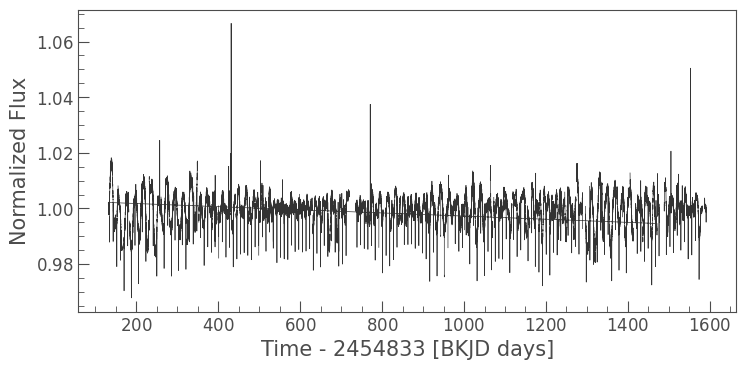

In [5]:
# %% Get the fits file and append them into a list
all_lightcurves = []        # a list that will contain all lightcurves.

main_folder = '000757450/'
fit_files = os.listdir(main_folder) 

for file in fit_files:
    path_to_file = os.path.join(main_folder, file)

    lightcurve_ts = TimeSeries.read(path_to_file, format='kepler.fits')
    lightcurve_ts.time.format = 'bkjd'

    lightcurve_lk = lk.LightCurve(data=lightcurve_ts, flux=lightcurve_ts['pdcsap_flux'], flux_err=lightcurve_ts['pdcsap_flux_err'])

    all_lightcurves.append(lightcurve_lk)

# %%
# Now generating a collection of all lightcurves
print("[INFO] Generating a collection of {} Lightcurves...".format(len(all_lightcurves)))

lightkurve_collection = lk.LightCurveCollection(all_lightcurves)

print("[INFO] Collection generated..")

# %%
# Stitching all the lightcurves.
stitched_lightcurves = lightkurve_collection.stitch()
stitched_lightcurves.plot()    # For some reason this isn't working

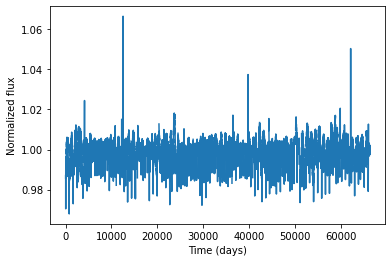

In [6]:
plt.plot(stitched_lightcurves['flux'])
plt.xlabel('Time (days)')
plt.ylabel('Normalized flux')

plt.savefig('test_plot.png')

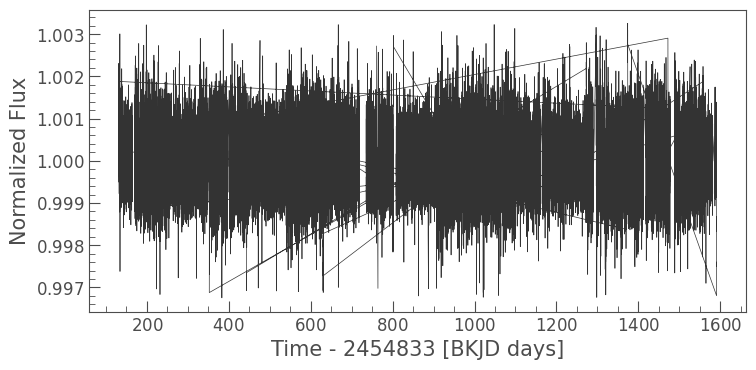

In [7]:
lc_flattened = stitched_lightcurves.flatten().remove_outliers()
lc_flattened.plot()


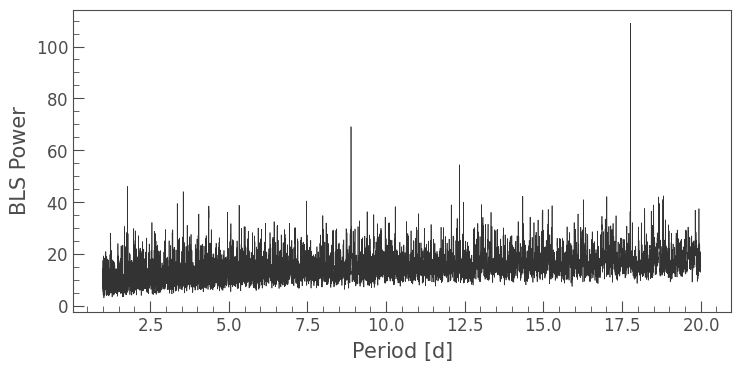

In [8]:
period = np.linspace(1, 20, 10000)
bls = lc_flattened.to_periodogram(method='bls', period=period, frequency_factor=500)
bls.plot()


(-1.0, 1.0)

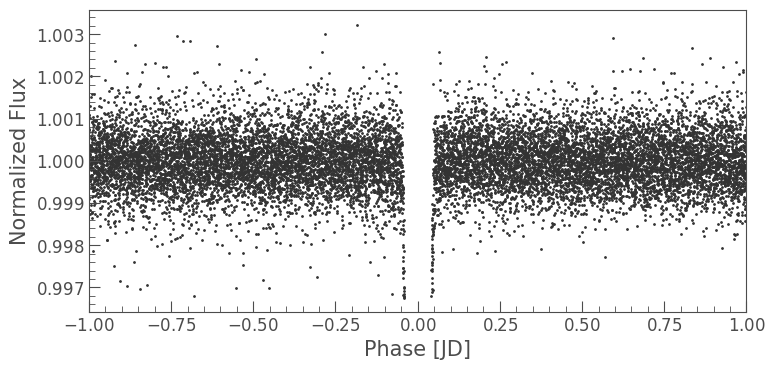

In [9]:
# %% FOLDING
p, t0 = 8.884920, 134.452       # TCE_PERIOD, TCE_TIME0bK
duration = bls.duration_at_max_power
period_t0 = bls.period_at_max_power
transit_t0 = bls.transit_time_at_max_power

folded_lc = lc_flattened.fold(period=p, epoch_time=t0).scatter()
# folded_lc.scatter()
folded_lc.set_xlim(-1, 1)
# folded_lc.set_ylim(0.98, 1.01)


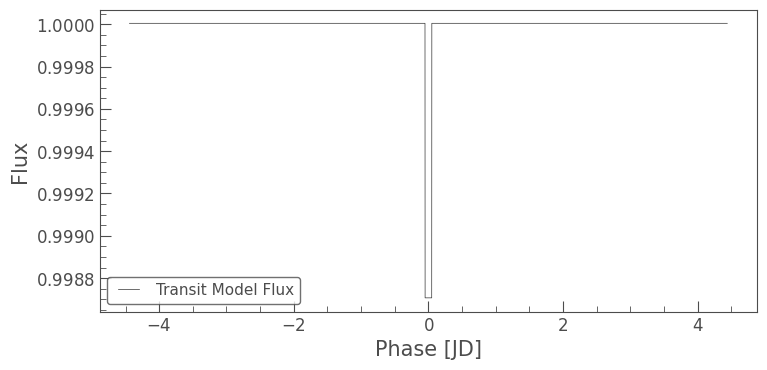

In [10]:
planet_model = bls.get_transit_model(period=p, transit_time=t0, duration=duration)

folded_lc = lc_flattened.fold(period=p, epoch_time=t0)
# folded_lc.scatter()

folded_planet = planet_model.fold(p, t0)
# folded_planet.plot(ax=folded_lc, c='r', lw=2)
# folded_planet.plot()
planet_model.fold(p, t0).plot()

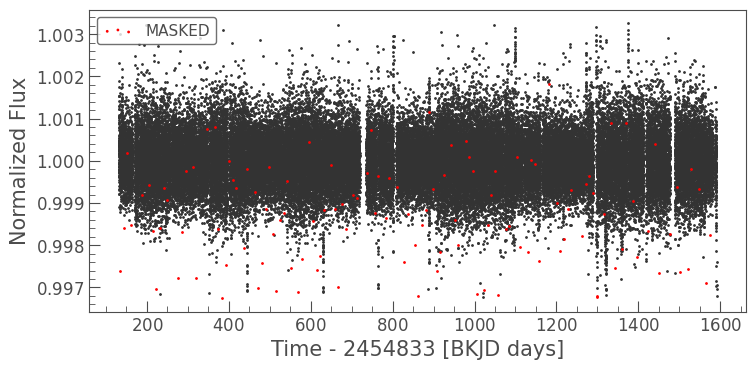

In [11]:
planet_b_mask = bls.get_transit_mask(period=p, transit_time=t0, duration=duration)
masked_lc = lc_flattened[~planet_b_mask]
ax = masked_lc.scatter()
lc_flattened[planet_b_mask].scatter(ax=ax, c='r', label='MASKED')

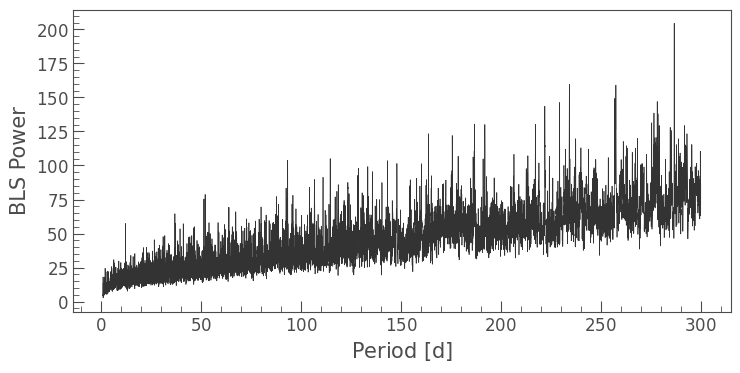

In [12]:
period = np.linspace(1, 300, 10000)     # general value -- increase the max (i.e. 300) if there's another planet you would like to find.
bls = masked_lc.to_periodogram('bls', period=period, frequency_factor=500)
bls.plot()


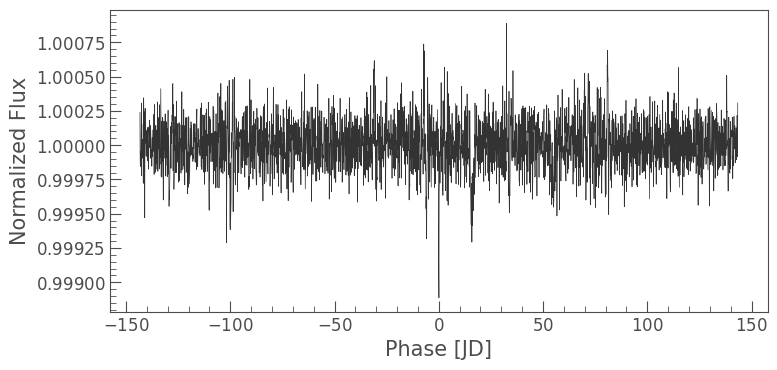

In [13]:
planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power


# We again plot the phase folded lightcurve to examine the transit
ax = masked_lc.fold(planet_c_period, planet_c_t0).bin(0.1)
# ax.plot(ax=ax, c='r', lw=2, label='Binned Flux')
ax.plot()

Bokeh show_app is currently unsupported


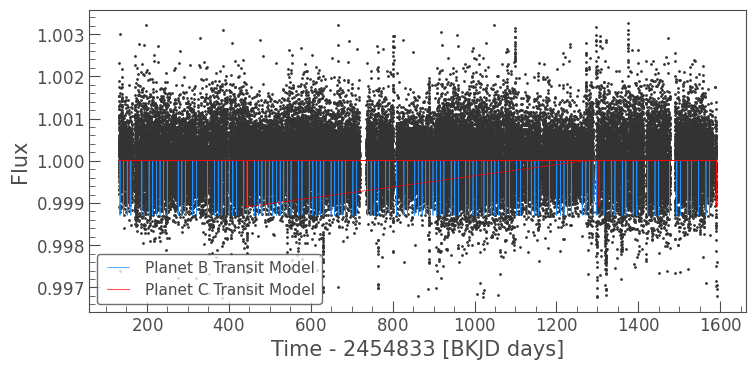

In [14]:
planet_c_model = bls.get_transit_model(period=planet_c_period,
                                        transit_time = planet_c_t0,
                                        duration = planet_c_dur)

ax = lc_flattened.scatter()
lc_flattened.interact_bls(notebook_url='localhost:8000', resolution=2000)
planet_model.plot(ax=ax, c='dodgerblue', label='Planet B Transit Model')
planet_c_model.plot(ax=ax, c='r', label='Planet C Transit Model')